# Web Scraping Indeed for Key Mechanical Engineering Job Skills

## Scroll Down Until you see START HERE

The basic workflow of the program will be:

- Enter the city we want to search for jobs in matching the title "mechanical engineer" (in quotes so it is a direct match) on Indeed.com
- See the list of job postings displayed by the website
- Access the link to each job posting
- Scrape all of the html in the job posting
- Filter it to only include words
- Reduce the words to a set so that each word is only counted once
- Keep a running total of the words and see how often a job posting included them

We will create two functions. The first will scape an individual job posting for the HTML, clean it up to get the words only, then output the final list of words. The second will manage which URLs to access via the job postings Indeed's website links to. 

In this notebook, we will use the urllib2 library to connect to the websites, the BeautifulSoup library to collect all of the HTML, the re library for parsing the words and filtering out other markup based on regular expressions, and pandas to manage and plot the final results. 

## The First Function: Cleaning a Website

This function will be called every time we access a new job posting. Its input is a URL for a website, while the output will be a final set of words collected from that website. 

In this notebook, I am going to import all of the libraries necessary first. 

In [1]:
from bs4 import BeautifulSoup # For HTML parsing
import urllib2 # Website connections
import re # Regular expressions
from time import sleep # To prevent overwhelming the server between connections
from collections import Counter # Keep track of our term counts
from nltk.corpus import stopwords # Filter out stopwords, such as 'the', 'or', 'and'
import pandas as pd # For converting results to a dataframe and bar chart plots
%matplotlib inline

Now create our first website parsing function.

In [2]:
def text_cleaner(website):
    '''
    This function just cleans up the raw html so that I can look at it.
    Inputs: a URL to investigate
    Outputs: Cleaned text only
    '''
    try:
        site = urllib2.urlopen(website).read() # Connect to the job posting
    except: 
        return   # Need this in case the website isn't there anymore or some other weird connection problem 
    
    soup_obj = BeautifulSoup(site, "html5lib") # Get the html from the site
    
    if len(soup_obj) == 0: # In case the default parser lxml doesn't work, try another one
        soup_obj = BeautifulSoup(site, 'html5lib')
    
    
    for script in soup_obj(["script", "style"]):
        script.extract() # Remove these two elements from the BS4 object
    
    

    text = soup_obj.get_text() # Get the text from this

    

    lines = (line.strip() for line in text.splitlines()) # break into lines

    
    
    chunks = (phrase.strip() for line in lines for phrase in line.split("  ")) # break multi-headlines into a line each
    

    text = ''.join(chunk for chunk in chunks if chunk).encode('utf-8') # Get rid of all blank lines and ends of line
    
    # Now clean out all of the unicode junk (this line works great!!!)
    
    try:
        text = text.decode('unicode_escape').encode('ascii', 'ignore') # Need this as some websites aren't formatted
    except:                                                            # in a way that this works, can occasionally throw
        return                                                         # an exception
   
    
    text = re.sub("[^a-zA-Z+3]"," ", text)  # Now get rid of any terms that aren't words (include 3 for d3.js)
                                             # Also include + for C++
    text = re.sub(r"([a-z])([A-Z])", r"\1 \2", text) # Fix spacing issue from merged words
    
    text = text.lower().split()  # Go to lower case and split them apart
    
    
    stop_words = set(stopwords.words("english")) # Filter out any stop words
    text = [w for w in text if not w in stop_words]
    
    
    
    text = list(set(text)) # Last, just get the set of these. Ignore counts (we are just looking at whether a term existed
                           # or not on the website)
    
    return text

As you can see in the code above, a lot of cleaning for the raw html is necessary to get the final terms we are looking for. It extracts the relevant portions of the html, gets the text, removes blank lines and line endings, removes unicode, and filters with regular expressions to include only words. To see what the final result looks like, let's try calling this function on a sample job posting. The one I am using is a job posting for a [Data Scientist at Indeed itself](http://www.indeed.com/viewjob?jk=5505e59f8e5a32a4&q=%22data+scientist%22&tk=19ftfgsmj19ti0l3&from=web&advn=1855944161169178&sjdu=QwrRXKrqZ3CNX5W-O9jEvWC1RT2wMYkGnZrqGdrncbKqQ7uwTLXzT1_ME9WQ4M-7om7mrHAlvyJT8cA_14IV5w&pub=pub-indeed)!

If you are reading the notebook interactively, the example job posting may have disappeared so you can try your own to see how the function works. 

In [3]:
# sample = text_cleaner('http://www.indeed.com/viewjob?jk=5505e59f8e5a32a4&q=%22data+scientist%22&tk=19ftfgsmj19ti0l3&from=web&advn=1855944161169178&sjdu=QwrRXKrqZ3CNX5W-O9jEvWC1RT2wMYkGnZrqGdrncbKqQ7uwTLXzT1_ME9WQ4M-7om7mrHAlvyJT8cA_14IV5w&pub=pub-indeed')
sample = text_cleaner('http://www.indeed.com/viewjob?jk=5505e59f8e5a32a4&q=%22analytics+manager%22&tk=19ftfgsmj19ti0l3&from=web&advn=1855944161169178&sjdu=QwrRXKrqZ3CNX5W-O9jEvWC1RT2wMYkGnZrqGdrncbKqQ7uwTLXzT1_ME9WQ4M-7om7mrHAlvyJT8cA_14IV5w&pub=pub-indeed')
sample[:20] # Just show the first 20 words

['saying',
 'code',
 'help',
 'cj',
 'indeed',
 'competitive',
 'detail',
 'scientist',
 'frequency',
 'human',
 'keywords',
 'follow',
 'alt',
 'decisions',
 'find',
 'jobse',
 'looking',
 'style',
 'retirement',
 'wc']

Now that we can extract terms from the website with our text_cleaner function, let's build another function that will call this and automatically loop through all of the websites on Indeed for us.

## The Second Function: Accessing the Job Postings

This next function will allow us to search for "mechanical engineer" jobs in a particular city (or nationally if we want to see everything!) and plot the final results in a bar chart so we can see which skills are most frequently desired. 

This second function is fairly long, so I will try to explain how everything works through a lot of commentary. The basic idea is to look through Indeed's pages of job results and click on all of the job links, but only in the center of the page where all of the jobs are posted (not on the edges). See an example [here](http://www.indeed.com/jobs?q=%22data+scientist%22&l=). I just want the URLs in the "center" column of the website. You can get an idea of how Indeed organized the website by using a browser like Firefox or Chrome. Right click on the page to see the "Inspect Element" option in Firefox and the HTML will now be visible to you.

## START HERE

Here's where you define skills. Right now the categories are all data-sciency. It's probably best to leave the categories named the way they are, but change what's inside. For example you could take

``` Python
def get_prog_lang_dict():
    prog_lang_dict = Counter({'R':doc_frequency['r'], 'Python':doc_frequency['python'],
                    'Java':doc_frequency['java'], 'C++':doc_frequency['c++'],
                   'Ruby':doc_frequency['ruby'],
                  'Perl':doc_frequency['perl'], 'Matlab':doc_frequency['matlab'],
                  'JavaScript':doc_frequency['javascript'], 'Scala': doc_frequency['scala']})
    return prog_lang_dict
```

and turn it into ....

``` Python
def get_prog_lang_dict():
    prog_lang_dict = Counter({'Autodesk':doc_frequency['autodesk'], 'SolidWorks':doc_frequency['solidworks']
    })
    return prog_lang_dict
```

Make sure your parenthesis and curely braces stay balanced. If you want to skip a category entirely, scroll down to **Here's where you put it all together.**

In [4]:
def get_cad_tool_dict(doc_frequency):
    cad_tool_dict = Counter({
        'Autodesk':doc_frequency['autodesk'], 
        'SolidWorks':doc_frequency['solidworks'],
        'AutoCAD':doc_frequency['autocad'], 
        'Inventor':doc_frequency['inventor'],
        'Revit':doc_frequency['revit'],
        'Creo':doc_frequency['creo'], 
        'CATIA':doc_frequency['catia']
    })
    return cad_tool_dict

In [5]:
def get_analysis_tool_dict(doc_frequency):
    analysis_tool_dict = Counter({
        'Matlab':doc_frequency['matlab'],
        'simulink':doc_frequency['simulink'],
        'LABview':doc_frequency['labview'], 
        'Ansys':doc_frequency['ansys'], 
        'SAS':doc_frequency['sas'],
        'Abaqus':doc_frequency['Abaqus']
    })  
    return analysis_tool_dict

In [6]:
 def get_hadoop_dict(doc_frequency):
    hadoop_dict = Counter({
        'Hadoop':doc_frequency['hadoop'],
        'MapReduce':doc_frequency['mapreduce'],
        'Spark':doc_frequency['spark'],
        'Pig':doc_frequency['pig'],
        'Hive':doc_frequency['hive'], 
        'Shark':doc_frequency['shark'],
        'Oozie':doc_frequency['oozie'], 
        'ZooKeeper':doc_frequency['zookeeper'],
        'Flume':doc_frequency['flume'], 
        'Mahout':doc_frequency['mahout']
    })
    return get_hadoop_dict

In [7]:
def get_database_dict(doc_frequency):
    database_dict = Counter({
        'SQL':doc_frequency['sql'], 
        'NoSQL':doc_frequency['nosql'],
        'HBase':doc_frequency['hbase'], 
        'Cassandra':doc_frequency['cassandra'],
        'MongoDB':doc_frequency['mongodb']
    }) 
    return database_dict

In [8]:
def get_platform_dict(doc_frequency):
    platform_dict = Counter({
        'AWS':doc_frequency['aws'], 
        'Azure':doc_frequency['azure'], 
        'IoT':doc_frequency['iot'],
        'Docker':doc_frequency['docker'], 
        'GCP':doc_frequency['gcp'], 
        'IBM':doc_frequency['ibm']
    })
    return platform_dict

In [9]:
def get_manager_dict(doc_frequency):
    manager_dict = Counter({
        'PMP':doc_frequency['pmp'], 
        'Agile':doc_frequency['agile'],
        'Scrum':doc_frequency['scrum'], 
        'ITIL':doc_frequency['itil'], 
        'EVM':doc_frequency['evm']})
    return manager_dict

## Here's where you put it all together.
If you want, you can remove on or more of the categofies below.

In [10]:
# def get_all_skills(doc_frequency):
#    return get_cad_tool_dict(doc_frequency) + get_analysis_tool_dict(doc_frequency) + get_hadoop_dict(doc_frequency) + get_database_dict(doc_frequency) + get_platform_dict(doc_frequency) + get_manager_dict(doc_frequency)

In [11]:
def get_all_skills(doc_frequency):
    return get_cad_tool_dict(doc_frequency) + get_analysis_tool_dict(doc_frequency)

## Here is where the job title gets set.  Modify the vlaue of final_job

In [12]:
def skills_info(city = None, state = None):
    '''
    This function will take a desired city/state and look for all new job postings
    on Indeed.com. It will crawl all of the job postings and keep track of how many
    use a preset list of typical mechanical engineering skills. The final percentage for each skill
    is then displayed at the end of the collation. 
    
    Inputs: The location's city and state. These are optional. If no city/state is input, 
    the function will assume a national search (this can take a while!!!).
    Input the city/state as strings, such as skills_info('Chicago', 'IL').
    Use a two letter abbreviation for the state.
    
    Output: A bar chart showing the most commonly desired skills in the job market for 
    a mechanical engineer. 
    '''
    
    # ******** JOB TITLE ***************************
    final_job = 'mechanical+engineer'
    # final_job = 'design'
    # final_job = 'production'
    # final_job = 'product'
    # final_job = 'test'
    # ******** JOB TITLE ***************************
   
    # Make sure the city specified works properly if it has more than one word (such as San Francisco)
    if city is not None:
        final_city = city.split() 
        final_city = '+'.join(word for word in final_city)
        final_site_list = ['http://www.indeed.com/jobs?q=%22', final_job, '%22&l=', final_city,
                   '%2C+', state] # Join all of our strings together so that indeed will search correctly
    else:
        final_site_list = ['http://www.indeed.com/jobs?q="', final_job, '"']

    final_site = ''.join(final_site_list) # Merge the html address together into one string


    base_url = 'http://www.indeed.com'


    try:
        html = urllib2.urlopen(final_site).read() # Open up the front page of our search first
    except:
        'That city/state combination did not have any jobs. Exiting . . .' # In case the city is invalid
        return
    soup = BeautifulSoup(html, "html5lib") # Get the html from the first page

    # Now find out how many jobs there were

    num_jobs_area = soup.find(id = 'searchCount').string.encode('utf-8') # Now extract the total number of jobs found
                                                                         # The 'searchCount' object has this

    print num_jobs_area
    
    job_numbers = re.findall('\d+', num_jobs_area) # Extract the total jobs found from the search result
    print job_numbers

    if len(job_numbers) > 3: # Have a total number of jobs greater than 1000
        total_num_jobs = (int(job_numbers[2])*1000) + int(job_numbers[3])
    else:
        total_num_jobs = int(job_numbers[1]) 

    city_title = city
    if city is None:
        city_title = 'Nationwide'
    
    print 'There were', total_num_jobs, 'jobs found,', city_title # Display how many jobs were found

    num_pages = total_num_jobs/10 # This will be how we know the number of times we need to iterate over each new
                                  # search result page
    job_descriptions = [] # Store all our descriptions in this list

    for i in xrange(1,num_pages+1): # Loop through all of our search result pages
#    for i in xrange(1,2): # Loop through all of our search result pages
        print 'Getting page', i
        start_num = str(i*10) # Assign the multiplier of 10 to view the pages we want
        current_page = ''.join([final_site, '&start=', start_num])
        # Now that we can view the correct 10 job returns, start collecting the text samples from each
        
        html_page = urllib2.urlopen(current_page).read() # Get the page
        
        page_obj = BeautifulSoup(html_page, "html5lib") # Locate all of the job links
        
        job_link_area = page_obj.find(id = 'resultsCol') # The center column on the page where the job postings exist
        
        # job_URLS = [base_url + link.get('href') for link in job_link_area.find_all('a')] # Get the URLS for the jobs
        
        # BEGN LEO ============================================================================
                
        job_URLS = [base_url]
        
        # print "base is", job_URLS
        # print "finding all is", job_link_area.find_all('a')
        
        for link in job_link_area.find_all('a'):
            the_href = link.get('href')
            # print "link is", link
            # print " "
            # print "href is", the_href
          
            if not (the_href is None):
                new_url = base_url + link.get('href')
                # print "new url is ", new_url
                new_url_lst = [new_url.encode('utf-8')]
                # print "new_url_lst", new_url_lst
                job_URLS.extend(new_url_lst)
                # print "new job url is", job_URLS
            # else: 
                # print "NO href"
                                        
            # print " "
            # print " "

        
        # END LEO ============================================================================
        
        job_URLS = filter(lambda x:'clk' in x, job_URLS) # Now get just the job related URLS
        print '  found', len(job_URLS), 'jobs'
    
        for j in xrange(0,len(job_URLS)):
            final_description = text_cleaner(job_URLS[j])
            if final_description: # So that we only append when the website was accessed correctly
                job_descriptions.append(final_description)
            sleep(1) # So that we don't be jerks. If you have a very fast internet connection you could hit the server a lot! 
    
    print 'Done with collecting the job postings!'    
    print 'There were', len(job_descriptions), 'jobs successfully found.'


    doc_frequency = Counter() # This will create a full counter of our terms. 
    [doc_frequency.update(item) for item in job_descriptions] # List comp

    # Now we can just look at our final dict list inside doc_frequency

    # Obtain our key terms and store them in a dict. These are the key mechanical engineering skills we are looking for

    # prog_lang_dict = Counter({'R':doc_frequency['r'], 'Python':doc_frequency['python'],
    #                'Java':doc_frequency['java'], 'C++':doc_frequency['c++'],
    #               'Ruby':doc_frequency['ruby'],
    #              'Perl':doc_frequency['perl'], 'Matlab':doc_frequency['matlab'],
    #              'JavaScript':doc_frequency['javascript'], 'Scala': doc_frequency['scala']})
                  
    # analysis_tool_dict = Counter({'Excel':doc_frequency['excel'],  'Tableau':doc_frequency['tableau'],
    #                  'D3.js':doc_frequency['d3.js'], 'PowerBI':doc_frequency['poerbi'], 'SAS':doc_frequency['sas'],
    #                  'SPSS':doc_frequency['spss'], 'D3':doc_frequency['d3']})  


    # hadoop_dict = Counter({'Hadoop':doc_frequency['hadoop'], 'MapReduce':doc_frequency['mapreduce'],
    #           'Spark':doc_frequency['spark'], 'Pig':doc_frequency['pig'],
    #           'Hive':doc_frequency['hive'], 'Shark':doc_frequency['shark'],
    #           'Oozie':doc_frequency['oozie'], 'ZooKeeper':doc_frequency['zookeeper'],
    #           'Flume':doc_frequency['flume'], 'Mahout':doc_frequency['mahout']})
               

    # database_dict = Counter({'SQL':doc_frequency['sql'], 'NoSQL':doc_frequency['nosql'],
    #                 'HBase':doc_frequency['hbase'], 'Cassandra':doc_frequency['cassandra'],
    #                 'MongoDB':doc_frequency['mongodb']})  
    

    # platform_dict = Counter({'AWS':doc_frequency['aws'], 'Azure':doc_frequency['azure'], 'IoT':doc_frequency['iot'],
    #             'Docker':doc_frequency['docker'], 'GCP':doc_frequency['gcp'], 'IBM':doc_frequency['ibm']})
   

    # manager_dict = Counter({'PMP':doc_frequency['pmp'], 'Agile':doc_frequency['agile'],
    #             'Scrum':doc_frequency['scrum'], 'ITIL':doc_frequency['itil'], 'EVM':doc_frequency['evm']})

           
    # Combine our Counter objects
    overall_total_skills = get_all_skills(doc_frequency)
    # overall_total_skills = prog_lang_dict + analysis_tool_dict + hadoop_dict + database_dict + platform_dict + manager_dict

    final_frame = pd.DataFrame(overall_total_skills.items(), columns = ['Term', 'NumPostings']) # Convert these terms to a 
                                                                                                # dataframe 

    print final_frame
    
    # Change the values to reflect a percentage of the postings 

    final_frame.NumPostings = (final_frame.NumPostings)*100/len(job_descriptions) # Gives percentage of job postings 
                                                                                  #  having that term 

    # Sort the data for plotting purposes

    # final_frame.sort_values(['NumPostings', 'Term'], axis=1, ascending = False, inplace = True)
    final_frame = final_frame.sort_values('NumPostings', ascending = False)

    # Get it ready for a bar plot
    final_plot = final_frame.plot(x = 'Term', kind = 'bar', legend = None, 
                              title = 'Percentage of Mechanical Engineering Job Ads with a Key Skill, ' + city_title)
    
    final_plot.set_ylabel('Percentage Appearing in Job Ads')
    fig = final_plot.get_figure() # Have to convert the pandas plot object to a matplotlib object
    
    
    return fig, final_frame # End of the function

Let's now try running our new function on Seattle, Washington to see what results we get. Just as a note, all of these results were run on March 8, 2015 (with the exception of the national results that were run the next day). 

In [13]:
# skills_info()


            Page 1 of 83 jobs
['1', '83']
There were 83 jobs found, Seattle
Getting page 1
  found 14 jobs
Getting page 2
  found 15 jobs
Getting page 3
  found 18 jobs
Getting page 4
  found 12 jobs
Getting page 5
  found 16 jobs
Getting page 6
  found 15 jobs
Getting page 7
  found 15 jobs
Getting page 8
  found 15 jobs
Done with collecting the job postings!
There were 120 jobs successfully found.
          Term  NumPostings
0     simulink            2
1        CATIA            1
2      AutoCAD            1
3     Autodesk            3
4   SolidWorks            8
5      LABview            1
6       Matlab            6
7         Creo           11
8        Ansys           10
9        Revit           27
10    Inventor            6


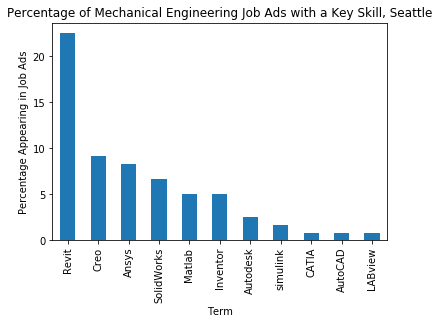

In [14]:
seattle_info = skills_info(city = 'Seattle', state = 'WA') 


            Page 1 of 107 jobs
['1', '107']
There were 107 jobs found, Chicago
Getting page 1
  found 10 jobs
Getting page 2
  found 14 jobs
Getting page 3
  found 16 jobs
Getting page 4
  found 14 jobs
Getting page 5
  found 17 jobs
Getting page 6
  found 16 jobs
Getting page 7
  found 16 jobs
Getting page 8
  found 14 jobs
Getting page 9
  found 18 jobs
Getting page 10
  found 14 jobs
Done with collecting the job postings!
There were 149 jobs successfully found.
         Term  NumPostings
0    Autodesk            6
1  SolidWorks           13
2        Creo           14
3       Ansys            1
4       Revit           23
5    Inventor            5


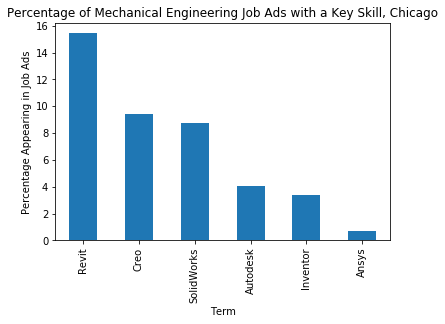

In [15]:
chicago_info = skills_info(city = 'Chicago', state = 'IL')


            Page 1 of 147 jobs
['1', '147']
There were 147 jobs found, San Francisco
Getting page 1
  found 14 jobs
Getting page 2
  found 15 jobs
Getting page 3
  found 15 jobs
Getting page 4
  found 15 jobs
Getting page 5
  found 18 jobs
Getting page 6
  found 16 jobs
Getting page 7
  found 13 jobs
Getting page 8
  found 14 jobs
Getting page 9
  found 17 jobs
Getting page 10
  found 14 jobs
Getting page 11
  found 18 jobs
Getting page 12
  found 17 jobs
Getting page 13
  found 15 jobs
Getting page 14
  found 14 jobs
Done with collecting the job postings!
There were 215 jobs successfully found.
         Term  NumPostings
0       CATIA            7
1     AutoCAD            3
2    Autodesk            2
3  SolidWorks           25
4      Matlab            6
5        Creo           11
6       Ansys            4
7       Revit           34
8    Inventor            4


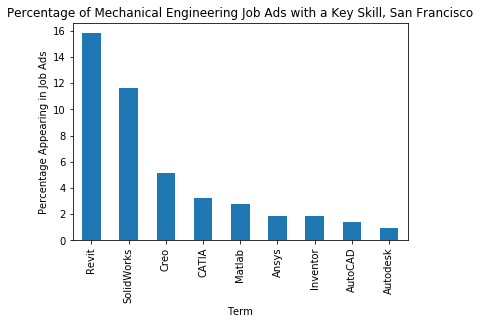

In [16]:
silicon_val_info = skills_info(city = 'San Francisco', state = 'CA')

In [17]:
nyc_info = skills_info(city = 'New York', state = 'NY')


            Page 1 of 1,536 jobs
['1', '1', '536']
There were 1 jobs found, New York
Done with collecting the job postings!
There were 0 jobs successfully found.
Empty DataFrame
Columns: [Term, NumPostings]
Index: []


TypeError: Empty 'DataFrame': no numeric data to plot

In [20]:
skills_info()


            Page 1 of 4,717 jobs
['1', '4', '717']
There were 4 jobs found, Nationwide
Done with collecting the job postings!
There were 0 jobs successfully found.
Empty DataFrame
Columns: [Term, NumPostings]
Index: []


TypeError: Empty 'DataFrame': no numeric data to plot